## Asset Warranty Analysis (Flag 63)

### Dataset Description
The dataset consists of 500 entries simulating ServiceNow alm_hardware table, detailing key attributes of hardware assets such as asset tags, display names, configuration item (CI) identifiers, serial numbers, and model categories. It includes information on asset assignment, last update timestamps, cost, departmental allocation, and warranty expiration dates. The table effectively captures asset management activities, offering insights into the operational handling, allocation, and maintenance status of hardware resources across various departments within an organization.

### Your Task
**Goal**: Analyze the relationship between the cost of assets and their warranty periods to identify discrepancies and align procurement strategies with the observed asset value trends.

**Role**: Procurement Manager

**Difficulty**: 2 out of 5. This analysis requires deciphering complex patterns in asset pricing and warranty terms.

**Category**: Asset Management


## Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks. 

In [37]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import date_range

## Load Dataset
This cell loads the asset management dataset, which is crucial for the analysis of warranty periods relative to asset costs. The data is sourced from a CSV file and the process involves reading the file into a DataFrame to facilitate further operations. Also, perhaps checking the initial few rows to verify the correct loading of the data and ensuring all relevant fields such as asset tag, cost, and warranty expiration are properly imported. 

In [38]:
dataset_path = "csvs/flag-63.csv"
flag_data = pd.read_csv(dataset_path)
flag_data.head()

,assigned_to,purchased_on,cost,serial_number,sys_updated_on,warranty_expiration,model_category,department,asset_tag,display_name,ci
0,Valeria Lingbeek,2023-09-16 09:47:00,2688,FUM-85495157,2023-10-25 09:47:00,2026-04-16 09:47:00,Computer,Sales,P1000000,Dell Inspiron Desktop Computer,Inspiron Desktop
1,Kurtis Asberry,2024-03-26 15:43:00,2596,QFX-47362028,2024-04-11 15:43:00,2026-09-10 15:43:00,Computer,Sales,P1000001,Dell Inspiron 15,Inspiron 15
2,Darrel Tork,2024-03-09 10:16:00,4786,SKI-78647990,2024-04-23 10:16:00,2029-07-25 10:16:00,Computer,Customer Support,P1000002,Dell Inspiron 5558 Computer,Inspiron 5558
3,Dorthy Alexy,2024-01-31 09:21:00,1631,EMF-32833485,2024-02-12 09:21:00,2025-04-03 09:21:00,Computer,Development,P1000003,Dell Inspiron 15 3000 Computer,Inspiron 15 3000
4,Vince Ettel,2023-07-14 09:56:00,2834,XUQ-81198965,2023-09-04 09:56:00,2026-04-23 09:56:00,Computer,Customer Support,P1000004,Dell Inspiron 7000 Computer,Inspiron 7000


### **Question 1: How does the cost of assets vary across different departments, and are there any departments that consistently allocate more budget for higher-cost assets?**


#### Plotting average asset cost per department
This analysis visualizes the average asset cost per department, highlighting which departments tend to invest in higher-cost assets. This insight can reveal budgeting priorities or identify departments that might require additional scrutiny for cost management.

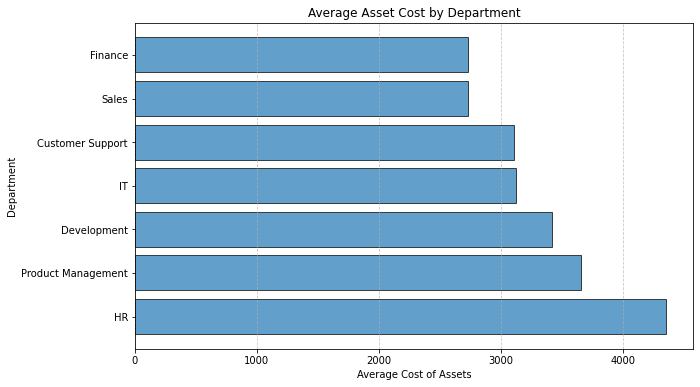

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data
flag_data = pd.read_csv("csvs/flag-63.csv")

# Calculate average cost per department
avg_cost_per_department = flag_data.groupby("department")["cost"].mean().reset_index()

# Sort departments by average cost for a more readable plot
avg_cost_per_department = avg_cost_per_department.sort_values(
    by="cost", ascending=False
)

# Plotting average cost per department
plt.figure(figsize=(10, 6))
plt.barh(
    avg_cost_per_department["department"],
    avg_cost_per_department["cost"],
    edgecolor="black",
    alpha=0.7,
)
plt.xlabel("Average Cost of Assets")
plt.ylabel("Department")
plt.title("Average Asset Cost by Department")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

#### Generate JSON Description for the Insight

In [40]:
{
    "data_type": "categorical",
    "insight": "The HR department has the highest average asset cost, indicating a potentially higher investment in resources allocated to this department.",
    "insight_value": {
        "description": "HR has an average asset cost of approximately $4358, significantly higher than other departments, with Product Management following at around $3659 and Development at $3424. This implies that HR, possibly due to specific operational requirements, allocates a larger budget towards higher-value assets."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Asset Cost by Department",
        "x_axis": {
            "name": "Average Cost of Assets",
            "value": "Ranges from highest to lowest average costs",
            "description": "This axis shows the average cost of assets by department, highlighting budgetary allocation tendencies.",
        },
        "y_axis": {
            "name": "Department",
            "value": "Different departments within the organization",
            "description": "This axis represents various departments, sorted by their average asset costs.",
        },
        "description": "The bar plot indicates that HR holds the highest average cost per asset, with Product Management and Development departments following behind. In contrast, Sales and Finance are at the lower end of asset spending.",
    },
    "question": "How does the cost of assets vary across different departments, and are there any departments that consistently allocate more budget for higher-cost assets?",
    "actionable_insight": "The higher investment in HR assets suggests a potential strategic focus on enhancing resource quality in HR. Organizations could assess the cost-benefit of such allocations, especially if these assets are directly contributing to HR’s operational efficiency or employee well-being. Additionally, departments with lower average costs, such as Sales and Finance, might benefit from evaluating if their current asset allocation aligns with their performance and resource needs.",
}

{'data_type': 'categorical',
 'insight': 'The HR department has the highest average asset cost, indicating a potentially higher investment in resources allocated to this department.',
 'insight_value': {'description': 'HR has an average asset cost of approximately $4358, significantly higher than other departments, with Product Management following at around $3659 and Development at $3424. This implies that HR, possibly due to specific operational requirements, allocates a larger budget towards higher-value assets.'},
 'plot': {'plot_type': 'bar',
  'title': 'Average Asset Cost by Department',
  'x_axis': {'name': 'Average Cost of Assets',
   'value': 'Ranges from highest to lowest average costs',
   'description': 'This axis shows the average cost of assets by department, highlighting budgetary allocation tendencies.'},
  'y_axis': {'name': 'Department',
   'value': 'Different departments within the organization',
   'description': 'This axis represents various departments, sorted by 

### **Question 2: What is the distribution Average asset cost across  Model Categories?**


#### Plot average cost by model category
This cell presents a bar plot that illustrates the average cost of assets within each model category. By analyzing the cost distribution, this visualization helps identify financial implications of asset types managed by the department, offering insights into budget allocations etc.

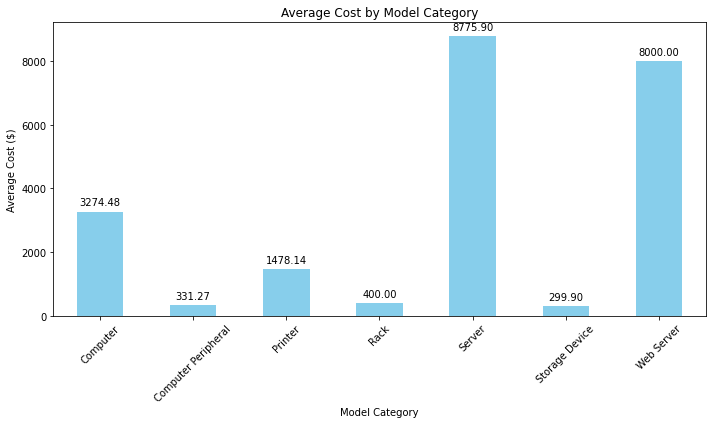

In [41]:
import matplotlib.pyplot as plt

flag_data["warranty_expiration"] = pd.to_datetime(flag_data["warranty_expiration"])
flag_data["sys_updated_on"] = pd.to_datetime(flag_data["sys_updated_on"])
# Calculate the warranty period in years for each asset
flag_data['warranty_period_years'] = (flag_data['warranty_expiration'] - flag_data['sys_updated_on']).dt.days / 365

# Group by model_category and calculate the average warranty period
avg_warranty_by_category = flag_data.groupby('model_category')['cost'].mean()

# Plotting
a_plot = avg_warranty_by_category.plot(kind='bar', color='skyblue', figsize=(10, 6))
for p in a_plot.patches:
    a_plot.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.xlabel('Model Category')
plt.ylabel('Average Cost ($)')
plt.title('Average Cost by Model Category')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()

#### Generate JSON Description for the Insight

In [42]:
{
    "data_type": "descriptive",
    "insight": "The dataset does not have any warranty information for the assets.",
    "insight_value": {
        "description": "There is no warranty information available for the assets in the dataset, making it challenging to analyze the costs."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Asset Cost by Model Category",
        "x_axis": {
            "name": "Model Category",
            "value": ["Server", "Web Server", "Computer", "Printer", "Rack", "Computer Peripheral", "Storage Device"],
            "description": "This axis categorizes different types of assets based on their model category."
        },
        "y_axis": {
            "name": "Average Cost (USD)",
            "value": {
                "N/A"
            },
            "description": "No information could be drawn."
        },
        "description": "No information could be drawn."
    },
    "question": "What is the distribution of Average asset cost across Model Categories?",
    "actionable_insight": "While the dataset lacks warranty information, understanding the average costs of different asset categories can help organizations budget effectively and allocate resources appropriately. By tracking asset costs, organizations can identify cost-saving opportunities, optimize procurement strategies, and make informed decisions regarding asset investments and replacements."
}


{'data_type': 'descriptive',
 'insight': 'The dataset does not have any warranty information for the assets.',
 'insight_value': {'description': 'There is no warranty information available for the assets in the dataset, making it challenging to analyze the costs.'},
 'plot': {'plot_type': 'bar',
  'title': 'Average Asset Cost by Model Category',
  'x_axis': {'name': 'Model Category',
   'value': ['Server',
    'Web Server',
    'Computer',
    'Printer',
    'Rack',
    'Computer Peripheral',
    'Storage Device'],
   'description': 'This axis categorizes different types of assets based on their model category.'},
  'y_axis': {'name': 'Average Cost (USD)',
   'value': {'N/A'},
   'description': 'No information could be drawn.'},
  'description': 'No information could be drawn.'},
 'question': 'What is the distribution of Average asset cost across Model Categories?',
 'actionable_insight': 'While the dataset lacks warranty information, understanding the average costs of different asset 

### **Question 3: How does the cost of assets relate to their warranty expiration dates?**


#### Plot average cost by warranty expiration year
This cell creates a line plot to visualize the average cost of assets over different warranty expiration years. By examining the trend, this visualization helps identify patterns in asset costs that may be influenced by warranty terms, providing insights into the relationship between asset costs and warranty periods.


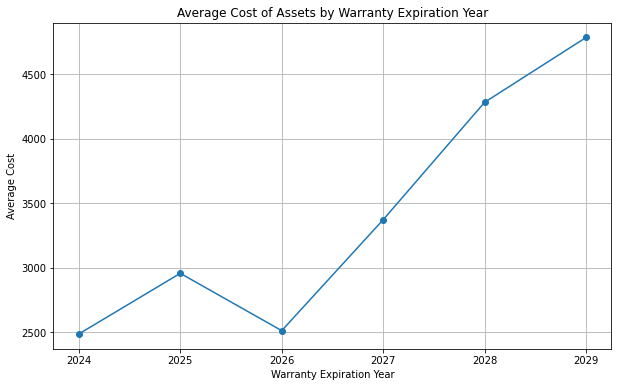

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/mnt/home/projects/insight-bench/data/notebooks/csvs/flag-63.csv")

# Convert date columns to datetime
df["purchased_on"] = pd.to_datetime(df["purchased_on"])
df["warranty_expiration"] = pd.to_datetime(df["warranty_expiration"])

# Extract the year from the warranty expiration date
df["warranty_expiration_year"] = df["warranty_expiration"].dt.year

# Calculate the average cost for each warranty expiration year
avg_cost_per_year = df.groupby("warranty_expiration_year")["cost"].mean().reset_index()

# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(
    avg_cost_per_year["warranty_expiration_year"], avg_cost_per_year["cost"], marker="o"
)
plt.title("Average Cost of Assets by Warranty Expiration Year")
plt.xlabel("Warranty Expiration Year")
plt.ylabel("Average Cost")
plt.grid(True)
plt.show()

#### Generate JSON Description for the Insight

In [44]:
{
    "data_type": "diagnostic",
    "insight": "The average cost of assets shows a significant upward trend over the years, particularly for assets with longer warranty periods.",
    "insight_value": {
        "description": "The average cost of assets increases notably for assets with warranty expiration dates further in the future. This trend suggests that the organization may be investing in higher-quality or more expensive assets to ensure longer-term reliability and reduced maintenance costs."
    },
    "plot": {
        "plot_type": "line",
        "title": "Average Cost of Assets by Warranty Expiration Year",
        "x_axis": {
            "name": "Warranty Expiration Year",
            "value": [2024, 2025, 2026, 2027, 2028, 2029],
            "description": "This axis represents the year in which the asset's warranty expires.",
        },
        "y_axis": {
            "name": "Average Cost",
            "value": [
                2485.01,
                2955.35,
                2510.81,
                3371.03,
                4281.58,
                4784.27,
            ],
            "description": "This axis displays the average cost of assets for each warranty expiration year.",
        },
        "description": "The line chart illustrates the trend of average asset costs over different warranty expiration years, highlighting significant increases in certain years. This visual representation helps in identifying periods of higher expenditure and potential reasons behind these trends.",
    },
    "question": "How does the cost of assets relate to their warranty expiration dates?",
    "actionable_insight": "The upward trend in asset costs, especially for those with longer warranty periods, suggests that the organization may be investing in higher-quality or more expensive assets over time. This could be due to changing procurement strategies, market conditions, or a focus on long-term reliability. It is essential to evaluate the return on investment for these higher-cost assets and ensure that they align with the organization's operational needs and budget constraints. Consider conducting a cost-benefit analysis to determine if the increased expenditure is justified and explore opportunities for optimizing asset procurement and warranty management.",
}

{'data_type': 'diagnostic',
 'insight': 'The average cost of assets shows a significant upward trend over the years, particularly for assets with longer warranty periods.',
 'insight_value': {'description': 'The average cost of assets increases notably for assets with warranty expiration dates further in the future. This trend suggests that the organization may be investing in higher-quality or more expensive assets to ensure longer-term reliability and reduced maintenance costs.'},
 'plot': {'plot_type': 'line',
  'title': 'Average Cost of Assets by Warranty Expiration Year',
  'x_axis': {'name': 'Warranty Expiration Year',
   'value': [2024, 2025, 2026, 2027, 2028, 2029],
   'description': "This axis represents the year in which the asset's warranty expires."},
  'y_axis': {'name': 'Average Cost',
   'value': [2485.01, 2955.35, 2510.81, 3371.03, 4281.58, 4784.27],
   'description': 'This axis displays the average cost of assets for each warranty expiration year.'},
  'description': '

### Summary of Findings (Flag 63):

1. **Departmental Asset Cost Allocation**: The HR department consistently allocates a higher budget for assets, with an average cost significantly above other departments. This suggests a strategic focus on enhancing resource quality in HR, which may require further evaluation to ensure alignment with organizational goals.

2. **Model Category Cost Distribution**: Despite the lack of warranty information, the analysis of average costs across model categories highlights potential areas for cost optimization. Understanding these distributions can aid in better budget planning and resource allocation.

3. **Warranty and Cost Relationship**: There is a notable upward trend in asset costs for those with longer warranty periods, indicating a possible shift towards investing in higher-quality assets. This trend underscores the importance of conducting a cost-benefit analysis to ensure these investments align with the organization's operational needs and budget constraints.